In [1]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np

np.random.seed(0)


import os
from requests import get
from pathlib import Path
import gc

from matplotlib import pyplot as plt
from zipfile import ZipFile

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
from tensorflow.keras.utils import plot_model

<IPython.core.display.Javascript object>

In [25]:
from thc_net.classifier import ThcNetClassifier
from thc_net.utils import download, plot_history
from thc_net.input_utils import prepare_input_data

<IPython.core.display.Javascript object>

# Bank marketing  : loading data

# Census income  : loading data

# Load data and split

In [7]:
if "Set" not in train.columns:
    train["Set"] = np.random.choice(
        ["train", "valid", "test"], p=[0.8, 0.1, 0.1], size=(train.shape[0],)
    )

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [8]:
Y = train[target].values
X = train.drop(columns=["Set"] + [target])

<IPython.core.display.Javascript object>

In [9]:
ratio = 0.005

<IPython.core.display.Javascript object>

In [10]:
n_unique = X.nunique()
ratios = (n_unique / X.shape[0]) < ratio
cat_idxs = np.argwhere(
    X.columns.isin(X.columns[ratios | (X.dtypes == "object")])
).ravel()
cat_dims = n_unique[cat_idxs].values + X.isnull().sum()[cat_idxs].values + 1
del n_unique, ratios, train

<IPython.core.display.Javascript object>

In [11]:
gc.collect()

635

<IPython.core.display.Javascript object>

# Training

In [12]:
tg_enc = LabelEncoder()
Y = tg_enc.fit_transform(Y)

<IPython.core.display.Javascript object>

In [13]:
X_train = X.values[train_indices]
y_train = Y[train_indices]

X_valid = X.values[valid_indices]
y_valid = Y[valid_indices]

X_test = X.values[test_indices]
y_test = Y[test_indices]

<IPython.core.display.Javascript object>

In [14]:
X_train.shape

(32976, 20)

<IPython.core.display.Javascript object>

In [15]:
X_train_prep, encoders = prepare_input_data(X_train, cat_idxs)
X_valid_prep, _ = prepare_input_data(X_valid, cat_idxs, encoders=encoders, fit=False)
X_test_prep, _ = prepare_input_data(X_test, cat_idxs, encoders=encoders, fit=False)

<IPython.core.display.Javascript object>

# Network parameters

In [ ]:
metrics = ['AUC']

In [16]:
%%time

model = ThcNetClassifier(
    n_layer=3,
    mul_input=8, 
    metrics=metrics,
    cat_idxs=cat_idxs,
    cat_emb_dims=cat_dims,
    dropout=0.05,
    normalize=False,
    max_emb=20,
    patience=30
)

history = model.fit(
        X=X_train_prep, 
        y=y_train,
        X_valid=X_valid_prep,
        y_valid=y_valid,
        batch_size=1024,
        epochs=10000,
        verbose=2,
)

Epoch 1/10000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
33/33 - 1s - loss: 0.3369 - val_loss: 0.2303
Epoch 2/10000
33/33 - 0s - loss: 0.2115 - val_loss: 0.2100
Epoch 3/10000
33/33 - 0s - loss: 0.1989 - val_loss: 0.1983
Epoch 4/10000
33/33 - 0s - loss: 0.1914 - val_loss: 0.1933
Epoch 5/10000
33/33 - 0s - loss: 0.1875 - val_loss: 0.1929
Epoch 6/10000
33/33 - 0s - loss: 0.1841 - val_loss: 0.1881
Epoch 7/10000
33/33 - 0s - loss: 0.1805 - val_loss: 0.1890
Epoch 8/10000
33/33 - 0s - loss: 0.1793 - val_loss: 0.1859
Epoch 9/10000
33/33 - 0s - loss: 0.1768 - val_loss: 0.1843
Epoch 10/10000
33/33 - 0s - loss: 0.1756 - val_loss: 0.1840
Epoch 11/10000
33/33 - 0s - loss: 0.1744 - val_loss: 0.1856
Epoch 12/10000
33/33 - 0s - loss: 0.1734 - val_loss: 0.1841
Epoch 13/10000
33/33 - 0s - loss: 0.1727 - val_loss: 0.1837
Epoch 14/10000
33/33 - 0s - loss: 0.1716 - val_loss: 0.1838
Epoch 15/10000
33/33 - 0s - loss: 0.1705 - val_loss: 0.1867
Epoch 16/10000
33/33 - 0s - 

<IPython.core.display.Javascript object>

In [17]:
%%time

model_snn = ThcNetClassifier(
    n_layer=3,
    mul_input=8, 
    metrics=metrics,
    cat_idxs=cat_idxs,
    cat_emb_dims=cat_dims,
    dropout=0.05,
    normalize=False,
    max_emb=20,
    patience=30,
    use_snn=True,
    noise=None
)

history_snn = model_snn.fit(
        X=X_train_prep, 
        y=y_train,
        X_valid=X_valid_prep,
        y_valid=y_valid,
        batch_size=1024,
        epochs=10000,
        verbose=2,
)

Epoch 1/10000
33/33 - 1s - loss: 0.5395 - auc: 0.8415 - val_loss: 0.3399 - val_auc: 0.9622
Epoch 2/10000
33/33 - 0s - loss: 0.2872 - auc: 0.9541 - val_loss: 0.2945 - val_auc: 0.9692
Epoch 3/10000
33/33 - 0s - loss: 0.2692 - auc: 0.9576 - val_loss: 0.2844 - val_auc: 0.9707
Epoch 4/10000
33/33 - 0s - loss: 0.2598 - auc: 0.9603 - val_loss: 0.2542 - val_auc: 0.9733
Epoch 5/10000
33/33 - 0s - loss: 0.2477 - auc: 0.9640 - val_loss: 0.2239 - val_auc: 0.9747
Epoch 6/10000
33/33 - 0s - loss: 0.2392 - auc: 0.9661 - val_loss: 0.2309 - val_auc: 0.9741
Epoch 7/10000
33/33 - 0s - loss: 0.2334 - auc: 0.9677 - val_loss: 0.2134 - val_auc: 0.9752
Epoch 8/10000
33/33 - 0s - loss: 0.2241 - auc: 0.9702 - val_loss: 0.2109 - val_auc: 0.9751
Epoch 9/10000
33/33 - 0s - loss: 0.2217 - auc: 0.9704 - val_loss: 0.2018 - val_auc: 0.9754
Epoch 10/10000
33/33 - 0s - loss: 0.2169 - auc: 0.9715 - val_loss: 0.2013 - val_auc: 0.9752
Epoch 11/10000
33/33 - 0s - loss: 0.2176 - auc: 0.9712 - val_loss: 0.1980 - val_auc: 0.97

33/33 - 0s - loss: 0.1761 - auc: 0.9804 - val_loss: 0.1836 - val_auc: 0.9785
Epoch 91/10000
33/33 - 0s - loss: 0.1765 - auc: 0.9803 - val_loss: 0.1800 - val_auc: 0.9793
Epoch 92/10000
33/33 - 0s - loss: 0.1758 - auc: 0.9804 - val_loss: 0.1860 - val_auc: 0.9778
Epoch 93/10000
33/33 - 0s - loss: 0.1767 - auc: 0.9802 - val_loss: 0.1861 - val_auc: 0.9777
Epoch 94/10000
33/33 - 0s - loss: 0.1749 - auc: 0.9807 - val_loss: 0.1807 - val_auc: 0.9790
Epoch 95/10000
33/33 - 0s - loss: 0.1749 - auc: 0.9806 - val_loss: 0.1829 - val_auc: 0.9787
Epoch 96/10000
33/33 - 0s - loss: 0.1764 - auc: 0.9804 - val_loss: 0.1835 - val_auc: 0.9784
Epoch 97/10000
33/33 - 0s - loss: 0.1765 - auc: 0.9802 - val_loss: 0.1845 - val_auc: 0.9783
Epoch 98/10000
33/33 - 0s - loss: 0.1750 - auc: 0.9807 - val_loss: 0.1835 - val_auc: 0.9785
Epoch 99/10000
33/33 - 0s - loss: 0.1734 - auc: 0.9810 - val_loss: 0.1846 - val_auc: 0.9783
Epoch 100/10000
33/33 - 0s - loss: 0.1747 - auc: 0.9807 - val_loss: 0.1828 - val_auc: 0.9788
Ep

<IPython.core.display.Javascript object>

In [18]:
model.network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

<IPython.core.display.Javascript object>

In [19]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


<IPython.core.display.Javascript object>

In [20]:
model_snn.network.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

<IPython.core.display.Javascript object>

### Predictions

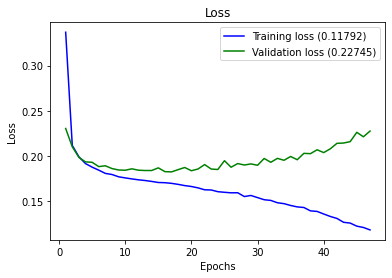

<IPython.core.display.Javascript object>

In [21]:
plot_history(history)

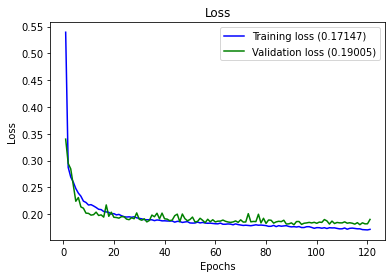

<IPython.core.display.Javascript object>

In [22]:
plot_history(history_snn)

In [23]:
y_pred = model.predict_proba(X_test_prep)
test_auc = roc_auc_score(y_score=y_pred[:, 1], y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

FINAL TEST SCORE FOR bank-additional-full : 0.9458906993511176


<IPython.core.display.Javascript object>

In [24]:
y_pred = model_snn.predict_proba(X_test_prep)
test_auc = roc_auc_score(y_score=y_pred[:, 1], y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

FINAL TEST SCORE FOR bank-additional-full : 0.9495036770007209


<IPython.core.display.Javascript object>